In [36]:
import time
import itertools
import re
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats

pd.set_option('display.max_rows', 50)
pd.set_option("display.max_columns", 50)

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb

## 【問題1】クロスバリデーション
事前学習期間では検証データをはじめに分割しておき、それに対して指標値を計算することで検証を行っていました。（ホールドアウト法）
しかし、分割の仕方により精度は変化します。実践的には クロスバリデーション（交差検証） を行います。
分割を複数回行い、それぞれに対して学習と検証を行う方法です。複数回の分割のためにscikit-learnにはKFoldクラスが用意されています。

事前学習期間の課題で作成したベースラインモデルに対してKFoldクラスによるクロスバリデーションを行うコードを作成し実行してください。

In [3]:
#データ読み込み
train = pd.read_csv("application_train.csv")
test  = pd.read_csv("application_test.csv")
sample = pd.read_csv("sample_submission.csv")

In [4]:
#今回用いる特徴量を選択
feats = ['EXT_SOURCE_1', 'EXT_SOURCE_3', 'EXT_SOURCE_2', 'DAYS_EMPLOYED',
         'DAYS_BIRTH', 'AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE',
         'DAYS_ID_PUBLISH', 'DAYS_REGISTRATION']

In [5]:
#欠損処理 ０埋めや平均値埋めを行う
train["EXT_SOURCE_1"] = train["EXT_SOURCE_1"].fillna(0)
train["EXT_SOURCE_2"] = train["EXT_SOURCE_1"].fillna(0)
train["EXT_SOURCE_3"] = train["EXT_SOURCE_1"].fillna(0)
train["AMT_ANNUITY"] = train["AMT_ANNUITY"].fillna(train["AMT_ANNUITY"].mean())
train["AMT_GOODS_PRICE"] = train["AMT_GOODS_PRICE"].fillna(train["AMT_GOODS_PRICE"].mean())

test["EXT_SOURCE_1"] = test["EXT_SOURCE_1"].fillna(0)
test["EXT_SOURCE_2"] = test["EXT_SOURCE_1"].fillna(0)
test["EXT_SOURCE_3"] = test["EXT_SOURCE_1"].fillna(0)
test["AMT_ANNUITY"] = test["AMT_ANNUITY"].fillna(test["AMT_ANNUITY"].mean())
test["AMT_GOODS_PRICE"] = test["AMT_GOODS_PRICE"].fillna(test["AMT_GOODS_PRICE"].mean())


In [6]:
X_train = train[feats]
y_train = train["TARGET"]

In [7]:
#ランダムフォレストを使って、クロスバリデーション（K=2）
scores = []

kf = KFold(n_splits=2, shuffle=True, random_state=1)
for tr_idx, va_idx in kf.split(X_train):
    tr_x, va_x = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    tr_y, va_y = y_train.iloc[tr_idx], y_train.iloc[va_idx]
    
    rand = RandomForestClassifier()
    rand.fit(tr_x, tr_y)
    
    pred = rand.predict_proba(va_x)[:, 1]
    score = roc_auc_score(va_y, pred)
    scores.append(score)
    
print("Average auc_score: %.4f" % np.mean(scores))    

Average auc_score: 0.6322


## 【問題2】グリッドサーチ
これまで分類器のパラメータには触れず、デフォルトの設定を使用していました。パラメータの詳細は今後のSprintで学んでいくことになります。  
機械学習の前提として、パラメータは状況に応じて最適なものを選ぶ必要があります。  
最適なパラメータを探していくことを パラメータチューニング と呼びます。  
パラメータチューニングをある程度自動化する単純な方法としては グリッドサーチ があります。  

scikit-learnのGridSearchCVを使い、グリッドサーチを行うコードを作成してください。  
そして、ベースラインモデルに対して何らかしらのパラメータチューニングを行なってください。  
どのパラメータをチューニングするかは、使用した手法の公式ドキュメントを参考にしてください。  

GridSearchCVクラスには引数としてモデル、探索範囲、さらにクロスバリデーションを何分割で行うかを与えます。  
クロスバリデーションの機能も含まれているため、これを使用する場合はKFoldクラスを利用する必要はありません。

**⇓概念を理解するためにやっていることを図で書いてみた⇓**

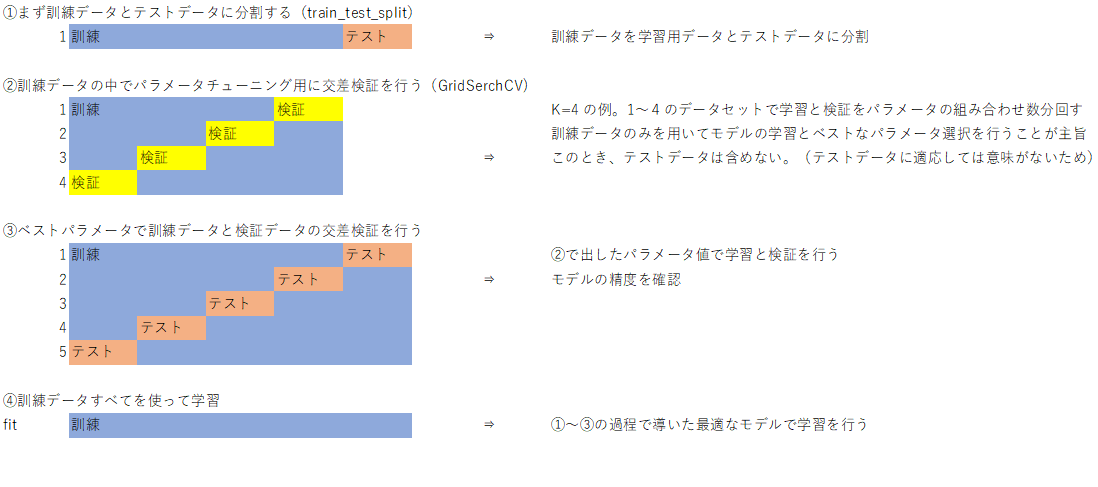

In [8]:
params = {"n_estimators":[100, 200],
           "max_depth":[3, 5, 7]
         }

grid_search = GridSearchCV(RandomForestClassifier(), params,
                           cv=2, n_jobs=-1, return_train_score=True, scoring="roc_auc")
grid_search.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7], 'n_estimators': [100, 200]},
             return_train_score=True, scoring='roc_auc')

In [9]:
grid_search.best_params_

{'max_depth': 7, 'n_estimators': 200}

## 【問題3】Kaggle Notebooksからの調査
KaggleのNotebooksから様々なアイデアを見つけ出して、列挙してください。

**<<調査記事>>**

https://www.kaggle.com/willkoehrsen/intro-to-model-tuning-grid-and-random-search

**<<調査して分かったこと>>**
* ここ最近の強力な予測ベースラインモデルは ligth-gbm（Gradient Boosting Machine）である。

    ★メリット
    - 欠損値をそのまま扱える
    - スケーリングなどの変換処理をする必要がない（大小関係が意味を成すため）
    - モデル訓練に掛かる時間が短い。計量値をヒストグラムとして扱うのでメモリ効率も高い
    
  ★デメリット
    - 「Leaf-wise」形式でモデルが複雑になるため、ハイパーパラメーターで適切に調整しないと過学習を起こしやすい


* 勾配ブースティングモデルの学習器の数（estimators）は early stopping を使うことでハイパーパラメータとしての調整は不要


* light-gbmの主なハイパーパラメータについて


     num_leaves：決定木の葉の数。モデルの複雑度を調整する事を意味する。max_depthと同時に調整すると良い
     min_data_in_leaf：決定木のノード（葉）の最小データ数を指定する。値が高いと決定木が深く育つのを防ぐ（過学習を防ぐ）

* ベイズ最適化の理論を用いたハイパーパラメーターの自動チューニングライブラリがあるらしい
    https://www.codexa.net/lightgbm-beginner/


**<<ハイパーパラメータのチューニングでの重要な４つの考え方>>**
* 目的関数：ハイパーパラメーターを最適化するための指標となるスコアを返す関数。  最小化・最大化を行いたい関数。二値分類の場合はauc
<br>
<br>
* ドメイン：モデルのハイパーパラメーターの試行する組み合わせ。その範囲。公式ドキュメントを参照するとよい
<br>
<br>
* アルゴリズム：試行するハイパーパラメータの選択をどのように決定するか
    * <u>グリッドサーチ：定義したパラメータの範囲を順番にすべての組み合わせを試行する</u>
        * 試行範囲を人間が定めるため、全体最適化されたパラメータを見つけれるとは限らない
        * 全ての組み合わせを試行するために計算コストが非常に高い
        * 逆にすべての組み合わせを試せれば、全体最適解に近い答えを求められるということになる。
        <br>
        <br>
    * <u>ランダムサーチ：定義したパラメータの範囲をランダムに指定回数分試行する</u>
        * 試行範囲を人間が定め、本当に全体最適化されたパラメータの組み合わせが見つかるとは限らない
        * ランダムにパラメータの組み合わせを決定し、学習・評価を行うため、少ない試行で最適解に近い組み合わせを調べられる
        * ランダムな選択であるため、試行回数があまりに低いと、最適解から遠い場合もある
        * 初手にランダムサーチを行い、パラメータの最適解周辺値を見極めた上で、グリッドサーチを行うという手法が効率が良い
         <br>
         <br>
    * <u>ベイジアン最適化：過去の結果を使用して、評価する次のパラメータを決定する</u>
        * ランダムにパラメータを決めながらも、評価が高いパラメータ組み合わせの周辺の学習・評価を繰り返し、短時間で最適解に近い答えを求める
        <br>
        <br>
* 実行履歴：各セットと目的関数から得られたスコアを含むデータ構造。dfで作るとわかりやすい


## 【問題4】高い汎化性能のモデル作成
問題3で見つけたアイデアと、独自のアイデアを組み合わせ高い汎化性能のモデル作りを進めてください。

その過程として、何を行うことで、クロスバリデーションの結果がどの程度変化したかを表にまとめてください。


**<<検証内容>>**

同じ特徴量・モデル（light-gmb）を用い以下７つの手法について、

計算時間、検証データの精度、テストデータの精度、Kaggleのスコアを検証する。

それぞれの結果を比較して、考察を行う

1. クロスバリデーションを行わない
2. クロスバリデーション（k=4）で検証、パラメータチューニングは行わない
3. クロスバリデーション（k-9）で検証、パラメータチューニングは行わない
4. クロスバリデーションで（k=4）で検証、グリッドサーチ（n=50）でパラメータチューニングを行う
5. クロスバリデーションで（k=4）で検証、ランダムサーチ（n=50）でパラメータチューニングを行う
6. クロスバリデーションで（k=4）で検証、ベイズ最適化（n=50）でパラメータチューニングを行う

### データ読込・特徴量選択・前処理

* 特徴量はapplication_trainの全てを用いる
* 前処理は二値のカテゴリ変数はlabel-encoding、三値以上はone-hot-encodingで処理する
* データ数が多いのでtrainデータの５万行を用いて処理

In [80]:
#データ再読み込み
train = pd.read_csv("application_train.csv")
test  = pd.read_csv("application_test.csv")
sample = pd.read_csv("sample_submission.csv")

train_x = train.drop(["TARGET", "SK_ID_CURR"], axis=1)
train_y = train["TARGET"]
test_x = test.copy()

print(train_x.shape)
print(test_x.shape)

(307511, 120)
(48744, 121)


In [81]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in train_x:
    if train_x[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(train[col].unique())) <= 2:
            # Train on the training data
            le.fit(train_x[col])
            # Transform both training and testing data
            train_x[col] = le.transform(train_x[col])
            test_x[col] = le.transform(test_x[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

# one-hot encoding of categorical variables
train_x = pd.get_dummies(train_x)
test_x = pd.get_dummies(test_x)

print('Training Features shape: ', train_x.shape)
print('Testing Features shape: ', test_x.shape)

3 columns were label encoded.
Training Features shape:  (307511, 241)
Testing Features shape:  (48744, 239)


In [82]:
train_x, test_x = train_x.align(test_x, join="inner", axis=1)

print('Training Features shape: ', train_x.shape)
print('Testing Features shape: ', test_x.shape)

Training Features shape:  (307511, 238)
Testing Features shape:  (48744, 238)


データ数が多いため今回は、trainデータ５万行を用いて各モデル比較を行う

In [83]:
#カラム名にJSON文字が入っているとエラーになるので加工
train_x = train_x.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test_x  =  test_x.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# xとyの対応が変わらないように、ランダムステートを記載すること
train_x_all = train_x.copy()
train_y_all = train_y.copy()

n = 50000
train_x = train_x.sample(n, random_state=0)
train_y = train_y.sample(n, random_state=0)

print(train_x_all.shape)
print(train_y_all.shape)
print(train_x.shape)
print(train_y.shape)

(307511, 238)
(307511,)
(50000, 238)
(50000,)


In [66]:

#学習データとテストデータを作成
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.25, random_state=1)

#lgb学習用のデータセットを作成
train_set = lgb.Dataset(data = X_train, label = y_train)
test_set = lgb.Dataset(data = X_test, label = y_test)
train_test_set = lgb.Dataset(data = train_x, label = train_y)

# 結果格納用のdfを作成
results = pd.DataFrame(columns=["thema", "train_time", "val_score", "test_score", "kaggle_score"],
           index=list(range(7)))

i = 0

### 1. クロスバリデーションを行わない

In [67]:
#モデルを定義、デフォルトのパラメータを取得
model = lgb.LGBMClassifier()
default_params = model.get_params()

#分類器の数はハイパーパラメータから除く ⇒ アーリーストッピングするため
del default_params["n_estimators"]

start = time.time()

model.fit(X_train, y_train)

t = time.time() - start

preds = model.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, preds)

results.loc[i, :] = ["not cv", t, np.nan, auc, np.nan]
i += 1

display(results)

,thema,train_time,val_score,test_score,kaggle_score
0,not cv,2.07101,NaN,0.724883,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN


### 2～3. クロスバリデーションを行う（k=4・9）

In [68]:

thema = {"cv(k=4)": 4, "cv(k=9)": 9}

for thema, cv in thema.items():
    
    start = time.time()
    cv_result = lgb.cv(default_params, train_set, num_boost_round=10000,
                       early_stopping_rounds=100, metrics="auc", nfold=cv, seed=1)
    t = time.time() - start
    
    results.loc[i, :] = [thema, t, np.nan, cv_result["auc-mean"][-1], np.nan]
    i += 1
    
display(results)

C:\Users\syous\AppData\Roaming\Python\Python38\site-packages\lightgbm\basic.py:840: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  warnings.warn('{0} keyword has been found in `params` and will be ignored.\n'


,thema,train_time,val_score,test_score,kaggle_score
0,not cv,2.07101,NaN,0.724883,NaN
1,cv(k=4),12.9548,NaN,0.737984,NaN
2,cv(k=9),28.469,NaN,0.739489,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN


In [84]:
# 全訓練データを用いて学習し、Kaggle に提出
model.fit(train_x_all, train_y_all)
pred = model.predict_proba(test_x)[:, 1]
sample["TARGET"] = pred
sample.to_csv("submit_no_params_tuning.csv", index=None)

In [158]:
results.loc[:2, "kaggle_score"] = 0.7428
display(results)

,thema,train_time,val_score,test_score,kaggle_score
0,not cv,2.07101,NaN,0.724883,0.7428
1,cv(k=4),12.9548,NaN,0.737984,0.7428
2,cv(k=9),28.469,NaN,0.739489,0.7428
3,grid_search(cv=4),3954.18,0.745913,0.743886,NaN
4,random_results(cv=4),3074,0.746071,0.744708,NaN
5,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN


**Kaggleの提出結果（チューニングなし）**

スコア：0.7428
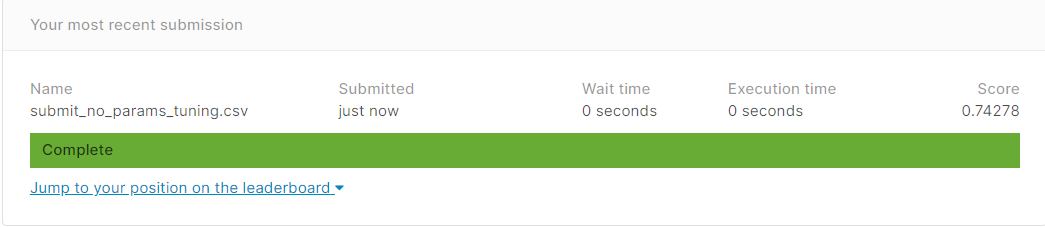

以上の結果より、クロスバリデーションのfold数が多いほど、実際のスコアと近い値が出る。  
今回のケースだとfold数によってかなり精度が異なるので、データセットの数が小さい場合はfold数を増やさないと適切なモデル比較が出来なくなってしまう。

### 4.クロスバリデーションで（k=4）で検証、グリッドサーチ（n=50）でパラメータチューニングを行う

In [86]:
# 交差検証で得られた学習器の数をパラメーターにセット
model.n_estimators = len(cv_result["auc-mean"])

**目的関数を作成**

In [144]:
def objective(hyperparameters, iteration):
    """Objective function for grid and random search. Returns
       the cross validation score from a set of hyperparameters."""
    
    # Number of estimators will be found using early stopping
    if 'n_estimators' in hyperparameters.keys():
        del hyperparameters['n_estimators']
    
     # Perform n_folds cross validation
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 500, nfold = 4, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 1)
    
    # results to retun
    score = cv_results['auc-mean'][-1]
    estimators = len(cv_results['auc-mean'])
    hyperparameters['n_estimators'] = estimators 
    
    return [score, hyperparameters, iteration]

**パラメータの範囲設定**

In [89]:
param_grid = {
    'boosting_type': ['gbdt', 'goss', 'dart'],
    'num_leaves': list(range(20, 150)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base = 10, num = 1000)),
    'subsample_for_bin': list(range(20000, 300000, 20000)),
    'min_child_samples': list(range(20, 500, 5)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.6, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'is_unbalance': [True, False]
}

In [102]:
# パラメータの組み合わせとその時のスコアを格納するDataFrame
MAX_EVALS = 50
random_results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))

grid_results = pd.DataFrame(columns = ['score', 'params', 'iteration'],
                              index = list(range(MAX_EVALS)))

グリッドサーチロジックの実装

In [106]:
def grid_search(param_grid, max_value = MAX_EVALS):
    results = pd.DataFrame(columns = ["score", "params", "iteration"], index = list(range(MAX_EVALS)))
    keys, values = zip(*param_grid.items())
    
    i = 0
    
    for v in itertools.product(*values):
        hyperparameters = dict(zip(keys, v))
        
        hyperparameters["subsample"] = 1.0 if hyperparameters["boosting_type"] == "goss" else hyperparameters["subsample"]
        
        eval_results = objective(hyperparameters, i)
        results.loc[i, :] = eval_results
        
        i += 1
        
        if i > MAX_EVALS:
            break
    
    results.sort_values("score", ascending=False, inplace=True)
    results.reset_index(inplace=True)
    
    return results

In [107]:
# グリッドサーチ実行
start = time.time()
grid_results = grid_search(param_grid)
t = time.time() - start

results.loc[3, :] = ["grid_search(cv=4)", t, grid_results.loc[0, "score"], np.nan, np.nan]

In [130]:
# ベストパラメータを取得
grid_search_params = grid_results.loc[0, "params"]

# グリッドサーチのベストパラメーターでテストデータでのスコア精度確認
cv_results = lgb.cv(grid_search_params, train_test_set, num_boost_round = 10000, nfold = 4, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 1)

results.loc[3, "test_score"] = cv_results["auc-mean"][-1]

C:\Users\syous\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [156]:
# グリッドサーチのベストパラメータで全訓練データを用いて学習し、Kaggle に提出
model = lgb.LGBMClassifier(**grid_search_params, random_state=42)
model.fit(train_x_all, train_y_all)
pred = model.predict_proba(test_x)[:, 1]
sample["TARGET"] = pred
sample.to_csv("submit_grid_params_tuning.csv", index=None)

In [165]:
results.loc[3, "kaggle_score"] = 0.74216
display(results)

,thema,train_time,val_score,test_score,kaggle_score
0,not cv,2.07101,NaN,0.724883,0.74278
1,cv(k=4),12.9548,NaN,0.737984,0.74278
2,cv(k=9),28.469,NaN,0.739489,0.74278
3,grid_search(cv=4),3954.18,0.745913,0.743886,0.74216
4,random_results(cv=4),3074,0.746071,0.744708,NaN
5,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN


**Kaggleに提出した結果**

スコア：0.74216
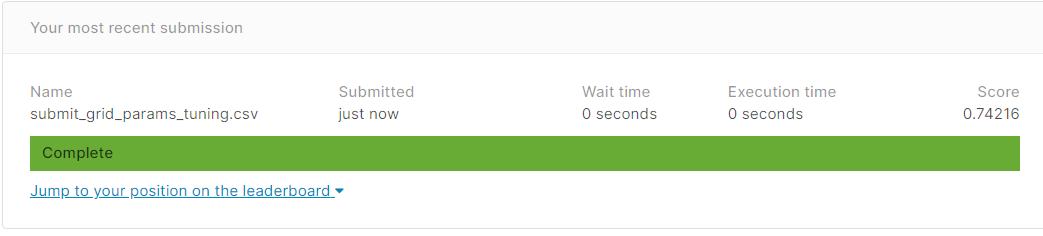

５０回試しただけでは、デフォルトパラメータの方が良いスコアを出した

### 5. クロスバリデーションで（k=4）で検証、ランダムサーチ（n=50）でパラメータチューニングを行う

ランダムサーチロジックの実装

In [148]:
def random_search(param_grid, max_evals=MAX_EVALS):
    # 返り値となるdfを作成
    results = pd.DataFrame(columns=["score", "params", "iteration"], index=list(range(max_evals)))
    
    # ランダムにパラメータを決定し、評価を繰り返す
    for i in range(max_evals):
        hyperparameters = {k: random.sample(v, 1)[0] for k, v in param_grid.items()}
        hyperparameters["subsample"] = 1.0 if hyperparameters["boosting_type"] == "goss" else hyperparameters["subsample"]
        
        # ランダムに選択されたパラメータで精度を評価
        eval_results = objective(hyperparameters, i)
        
        results.loc[i, :] = eval_results
        
    # 評価の高い順に結果を並べ替える
    results.sort_values("score", ascending=False, inplace=True)
    results.reset_index(inplace=True)
    return results

In [149]:
# ランダムサーチ実行
start = time.time()
random_results = random_search(param_grid)
t = time.time() - start

results.loc[4, :] = ["random_results(cv=4)", t, random_results.loc[0, "score"], np.nan, np.nan]

C:\Users\syous\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')
C:\Users\syous\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')
C:\Users\syous\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')
C:\Users\syous\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')
C:\Users\syous\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Ea

In [153]:
# ベストパラメータを取得
random_search_params = random_results.loc[0, "params"]

# グリッドサーチのベストパラメーターで学習を進める
cv_results = lgb.cv(random_search_params, train_test_set, num_boost_round = 10000, nfold = 4, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 1)

results.loc[4, "test_score"] = cv_results["auc-mean"][-1]

C:\Users\syous\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [166]:
# 全訓練データを用いて学習し、Kaggle に提出
model = lgb.LGBMClassifier(**random_search_params, random_state=42)

model.fit(train_x_all, train_y_all)
pred = model.predict_proba(test_x)[:, 1]
sample["TARGET"] = pred
sample.to_csv("submit_random_params_tuning.csv", index=None)

In [168]:
results.loc[4, "kaggle_score"] = 0.74032
display(results)

,thema,train_time,val_score,test_score,kaggle_score
0,not cv,2.07101,NaN,0.724883,0.74278
1,cv(k=4),12.9548,NaN,0.737984,0.74278
2,cv(k=9),28.469,NaN,0.739489,0.74278
3,grid_search(cv=4),3954.18,0.745913,0.743886,0.74216
4,random_results(cv=4),3074,0.746071,0.744708,0.74032
5,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN


**Kaggleの提出結果**

スコア：0.74032

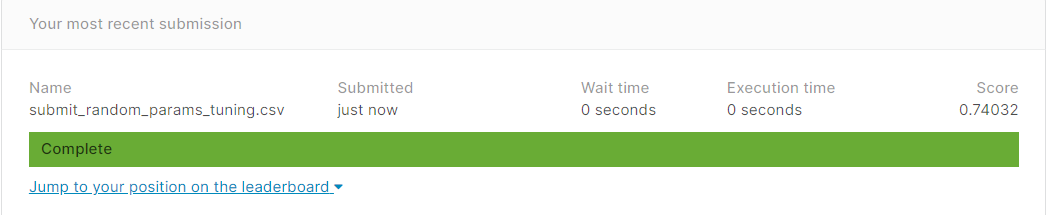

これまでで一番スコアの悪い結果となった。

### 6. クロスバリデーションで（k=4）で検証、ベイズ最適化（n=50）でパラメータチューニングを行う

In [182]:
from hyperopt import STATUS_OK
from hyperopt import hp
from hyperopt.pyll.stochastic import sample
from hyperopt import fmin
from hyperopt import Trials
from hyperopt import tpe
from timeit import default_timer as timer

In [183]:
def objective(hyperparameters):
    """Objective function for Gradient Boosting Machine Hyperparameter Optimization.
       Writes a new line to `outfile` on every iteration"""
    
    # Keep track of evals
    global ITERATION
    
    ITERATION += 1
    
    # Using early stopping to find number of trees trained
    if 'n_estimators' in hyperparameters:
        del hyperparameters['n_estimators']
    
    # Retrieve the subsample
    subsample = hyperparameters['boosting_type'].get('subsample', 1.0)
    
    # Extract the boosting type and subsample to top level keys
    hyperparameters['boosting_type'] = hyperparameters['boosting_type']['boosting_type']
    hyperparameters['subsample'] = subsample
    
    # Make sure parameters that need to be integers are integers
    for parameter_name in ['num_leaves', 'subsample_for_bin', 'min_child_samples']:
        hyperparameters[parameter_name] = int(hyperparameters[parameter_name])

    start = timer()
    
    # Perform n_folds cross validation
    cv_results = lgb.cv(hyperparameters, train_set, num_boost_round = 500, nfold = 4, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 50)

    run_time = timer() - start
    
    # Extract the best score
    best_score = cv_results['auc-mean'][-1]
    
    # Loss must be minimized
    loss = 1 - best_score
    
    # Boosting rounds that returned the highest cv score
    n_estimators = len(cv_results['auc-mean'])
    
    # Add the number of estimators to the hyperparameters
    hyperparameters['n_estimators'] = n_estimators

    # Dictionary with information for evaluation
    return {'loss': loss, 'hyperparameters': hyperparameters, 'iteration': ITERATION,
            'train_time': run_time, 'status': STATUS_OK}

In [184]:
# Define the search space
space = {
    'boosting_type': hp.choice('boosting_type', 
                                            [{'boosting_type': 'gbdt', 'subsample': hp.uniform('gdbt_subsample', 0.5, 1)}, 
                                             {'boosting_type': 'dart', 'subsample': hp.uniform('dart_subsample', 0.5, 1)},
                                             {'boosting_type': 'goss', 'subsample': 1.0}]),
    'num_leaves': hp.quniform('num_leaves', 20, 150, 1),
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.5)),
    'subsample_for_bin': hp.quniform('subsample_for_bin', 20000, 300000, 20000),
    'min_child_samples': hp.quniform('min_child_samples', 20, 500, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    'is_unbalance': hp.choice('is_unbalance', [True, False]),
}

In [185]:
# アルゴリズムを作成
tpe_algorithm = tpe.suggest
# 試行結果を記録するオブジェクトを作成
trials = Trials()

# Global variable
global  ITERATION

ITERATION = 0

# 最適化実行
start = time.time()
best = fmin(fn=objective, space=space, algo= tpe.suggest, trials = trials, max_evals = MAX_EVALS)
t = time.time() - start

best

  0%|                                                                           | 0/50 [00:00<?, ?trial/s, best loss=?]

C:\Users\syous\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



 22%|██████████▎                                    | 11/50 [04:46<13:44, 21.13s/trial, best loss: 0.25778104026572235]

C:\Users\syous\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



 24%|███████████▎                                   | 12/50 [07:25<39:25, 62.26s/trial, best loss: 0.25778104026572235]

C:\Users\syous\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



 26%|████████████▏                                  | 13/50 [09:55<54:46, 88.84s/trial, best loss: 0.25778104026572235]

C:\Users\syous\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



 28%|█████████████▏                                 | 14/50 [11:56<59:05, 98.48s/trial, best loss: 0.25778104026572235]

C:\Users\syous\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



 34%|███████████████▉                               | 17/50 [13:30<26:37, 48.41s/trial, best loss: 0.25677409479061186]

C:\Users\syous\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



 72%|██████████████████████████████████▌             | 36/50 [22:28<05:12, 22.33s/trial, best loss: 0.2538540486403478]

C:\Users\syous\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



 82%|███████████████████████████████████████▎        | 41/50 [25:21<03:36, 24.01s/trial, best loss: 0.2538540486403478]

C:\Users\syous\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



 88%|██████████████████████████████████████████▏     | 44/50 [27:15<03:18, 33.08s/trial, best loss: 0.2538540486403478]

C:\Users\syous\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



 96%|██████████████████████████████████████████████  | 48/50 [29:47<01:02, 31.08s/trial, best loss: 0.2538540486403478]

C:\Users\syous\AppData\Roaming\Python\Python38\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')



100%|████████████████████████████████████████████████| 50/50 [32:40<00:00, 39.21s/trial, best loss: 0.2538540486403478]


{'boosting_type': 0,
 'colsample_by_tree': 0.684060735242471,
 'gdbt_subsample': 0.7010255634816533,
 'is_unbalance': 1,
 'learning_rate': 0.01030011380722378,
 'min_child_samples': 490.0,
 'num_leaves': 93.0,
 'reg_alpha': 0.638108789124316,
 'reg_lambda': 0.8942155975811789,
 'subsample_for_bin': 200000.0}

In [ ]:
# ベストパラメータを取得
bayes_search_params = best

# グリッドサーチのベストパラメーターで学習を進める
cv_results = lgb.cv(bayes_search_params, train_test_set, num_boost_round = 10000, nfold = 4, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 1)



In [212]:
score = 1 - sorted(trials.results, key= lambda x: x["loss"])[0]["loss"]

results.loc[5, :] = ["bayes_search(cv=4)", t, score, np.nan, np.nan]

In [213]:
# ベストパラメータを選択
bayes_search_params = sorted(trials.results, key= lambda x: x["loss"])[0]["hyperparameters"]

cv_results = lgb.cv(bayes_search_params, train_test_set, num_boost_round = 500, nfold = 4, 
                        early_stopping_rounds = 100, metrics = 'auc', seed = 1)

results.loc[5, "test_score"] = cv_results["auc-mean"][-1]

C:\Users\syous\AppData\Roaming\Python\Python38\site-packages\lightgbm\engine.py:503: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [218]:
# 全訓練データを用いて学習し、Kaggle に提出
model = lgb.LGBMClassifier(**bayes_search_params, random_state=42)

model.fit(train_x_all, train_y_all)
pred = model.predict_proba(test_x)[:, 1]
sample["TARGET"] = pred
sample.to_csv("submit_bayes_params_tuning.csv", index=None)

In [220]:
results.loc[5, "kaggle_score"] = 0.74464
display(results)

,thema,train_time,val_score,test_score,kaggle_score
0,not cv,2.07101,NaN,0.724883,0.74278
1,cv(k=4),12.9548,NaN,0.737984,0.74278
2,cv(k=9),28.469,NaN,0.739489,0.74278
3,grid_search(cv=4),3954.18,0.745913,0.743886,0.74216
4,random_results(cv=4),3074,0.746071,0.744708,0.74032
5,bayes_search(cv=4),1960.3,0.746146,0.74376,0.74464
6,NaN,NaN,NaN,NaN,NaN


**Kaggleに提出した結果**

スコア：0.74464
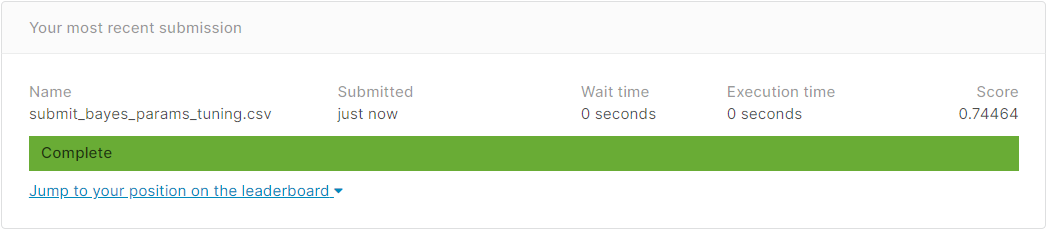

一番良い結果となった

## 【問題5】最終的なモデルの選定
最終的にこれは良いというモデルを選び、推定した結果をKaggleに提出してスコアを確認してください。

どういったアイデアを取り入れ、どの程度のスコアになったかを記載してください。

In [282]:
display(results)

,thema,train_time,val_score,test_score,kaggle_score
0,not cv,2.07101,NaN,0.724883,0.74278
1,cv(k=4),12.9548,NaN,0.737984,0.74278
2,cv(k=9),28.469,NaN,0.739489,0.74278
3,grid_search(cv=4),3954.18,0.745913,0.743886,0.74216
4,random_results(cv=4),3074,0.746071,0.744708,0.74032
5,bayes_search(cv=4),1960.3,0.746146,0.74376,0.74464


上の表の結果の通り、light-gbmモデルにベイズ最適化を用いたことで最も汎化性能の高いモデルができた。
また今回は50,000サンプルの訓練データを用いて検証時のスコア比較を行ったが、クロスバリデーションの分割数が多いほどKaggle提出時のスコアに近い値が得られた。

## まとめ・考察

実務においては答えのない中でどのモデルが一番精度が高いのかを正確に掴む必要性がある。
未知のデータに対しての精度を厳密に測るには、そのデータセットの量にも依るが、交差検証を十分に行い、ブレやノイズを極力少なくした指標値を比較する重要性を学んだ。
また、パラメーターチューニングにおいては、限られた時間の中でコスパのよいチューニング法としてはベイズ最適化の手法が有用であることを学んだ。